### Plots SIR and CS examples

In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from rnpe.utils import get_manual_legend, pairplot
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
import string

sns.set_context("paper")
sns.set_style('whitegrid', {'font.family':'Times New Roman', 'font.serif':'serif', "font.size": 11})
colors = ["#072D41", "#5ac5e0", "#ECA918", "#359735"]  # Using slightly brighter blue here for better contrast
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.axisbelow'] = True
results_dir = "../../results"
slab_scale = 0.25
hyperprior = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper function

In [5]:
def misspecified_barplot(res, ax):
    "Plots posterior misspecification probabilities"
    misspecified = res["mcmc_samples"]["misspecified"].mean(axis=0)
    order = np.argsort(misspecified)
    misspecified = misspecified[order]
    names = [res["names"]["x"][i] for i in order]
    sns.barplot(x=misspecified, y=names, color=colors[2], ax=ax)
    ax.set_xlabel("Posterior Misspecification \nProbability")
    ax.set_xticks([0, 0.5, 1])
    ax.tick_params(axis="y", direction="out", pad=0)


def missecified_density(res, ax, n = 10000):
    "Plots a density of the denoised samples for the most misspecified summary statistic"
    n = 10000
    idx = res["mcmc_samples"]["misspecified"].mean(axis=0).argmax()
    name = res["names"]["x"][idx]

    df = pd.DataFrame({
            "Simulations": np.random.permutation(res["data"]["x"])[:n, idx],
            "Denoised": np.random.permutation(res["mcmc_samples"]["x"])[:n, idx]
        })

    df = df.melt(value_name=name, var_name="Source")
    df["Source"] = pd.Categorical(df["Source"], ["Simulations", "Denoised"])

    sns.kdeplot(
        x = name,
        hue="Source",
        ax=ax,
        data=df,
        palette=[colors[0], colors[2]],
    )
    ax.set_yticks([])
    ax.get_legend().set_title(None)
    ax.axvline(res["data"]["y"][idx], color=colors[-1]) # True

def denoised_pairplot(res, thin_denoised = 10, legend_pos=(0.8,0.8), **kwargs):
    denoised = {
        "Simulations": res["data"]["x"][:10000],
        "Denoised": res["mcmc_samples"]["x"][::thin_denoised] # 10,000 values
    }

    fig = pairplot(
        denoised, res["data"]["y"],
        res["names"]["x"],
        true_name="Observed",
        colors=[colors[i] for i in [0, 2, -1]],
        legend_pos=legend_pos,
        true_point_size=10,
        **kwargs);

    fig.set_size_inches(4, 3.5)
    return fig


### SIR example

In [6]:
# Read in and format data
f_name = f"{results_dir}/SIR/2_{slab_scale}_{hyperprior}.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)

In [7]:
# Dataframe for posteriors
def supported_only(theta):
    a = theta[:, 0] > theta[:, 1]
    b = theta[:, 0] < 0.5
    return theta[a & b]

thetas_d = {
    "Prior": res["data"]["theta"],
    "NPE": supported_only(res["posterior_samples"]["NPE"]),
    "RNPE": supported_only(res["posterior_samples"]["RNPE"])
    }

thetas = []
for source, samples in thetas_d.items():
    thetas.append(
        pd.DataFrame({
            res["names"]["theta"][0]: samples[:, 0],
            res["names"]["theta"][1]: samples[:, 1],
            "Source": source
        })
    )

thetas = pd.concat(thetas)


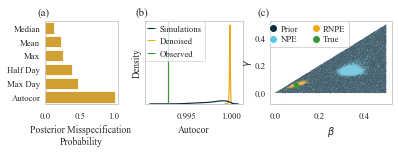

In [8]:
# Plot
fig, ax = plt.subplots(1, 3, figsize=(5.5, 2), gridspec_kw={'width_ratios': [0.6, 0.8, 1]})
plt. subplots_adjust()

misspecified_barplot(res, ax[0]) # a
missecified_density(res, ax[1]) # b
handles = get_manual_legend(["Simulations", "Denoised", "Observed"], [colors[0], colors[2], colors[-1]], marker="_")
ax[1].legend(handles=handles, borderaxespad=0 , handlelength=0.4)

# plot c
sns.scatterplot(
    x=res["names"]["theta"][0],
    y=res["names"]["theta"][1],
    data=thetas,
    hue="Source",
    ax=ax[2],
    s=0.2,
    palette=[colors[0], colors[1], colors[2]],
    rasterized=True
)
ax[2].scatter(x=res["data"]["theta_true"][0], y=res["data"]["theta_true"][1], color=colors[-1])
ax[2].get_legend().set_title(None)
handles = get_manual_legend(["Prior", "NPE", "RNPE", "True"], colors)
ax[2].legend(handles=handles, borderaxespad=0, loc="upper left", ncol=2, handlelength=0, labelspacing=0.3, framealpha=1)
ax[2].tick_params(axis="y", direction="out", pad=0)
ax[2].set_ylabel(ax[2].get_ylabel(), labelpad=0)

for n, ax in enumerate(ax):
    ax.text(-0.1, 1.08, f"({string.ascii_lowercase[n]})", transform=ax.transAxes, 
            size=11)
plt.subplots_adjust(left=0.115,
                    bottom=0.3, 
                    right=0.99, 
                    top=0.875, 
                    wspace=0.28)
plt.savefig(f"{results_dir}/plots/sir_example.pdf", dpi=600)

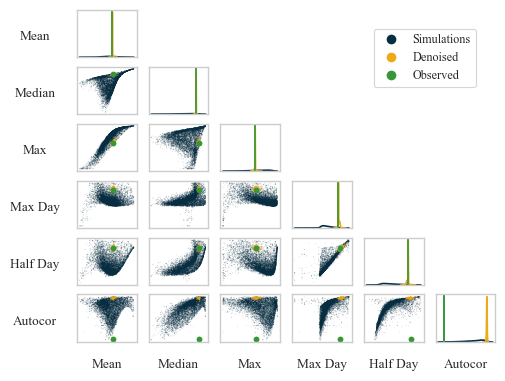

In [9]:
## Pairplot
fig = denoised_pairplot(res, legend_pos=(0.875, 0.85));
yaxes = [ax for ax in fig.get_axes() if ax.get_ylabel() != ""]
label_pad = 13
for ax in yaxes:
    ax.set_ylabel(ax.get_ylabel(), rotation=0)
    ax.yaxis.set_label_coords(x=-0.7, y=0.3)
fig.set_size_inches(5.4, 4.4)
fig.savefig(f"{results_dir}/plots/sir_denosied_pairplot.pdf", bbox_inches="tight", dpi=400)

### CS example

In [15]:
# Read in and format data
f_name = f"{results_dir}/CS/0_{slab_scale}_{hyperprior}.pickle"
with open(f_name, "rb") as f:
    res = pickle.load(f)


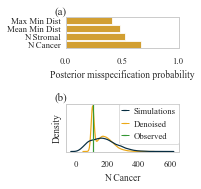

In [11]:
# Plot
fig, ax = plt.subplots(2, 1, figsize=(5.5/2, 5.5/2), gridspec_kw={'height_ratios': [0.4, 0.6]})
plt. subplots_adjust()

misspecified_barplot(res, ax[0]) # a
ax[0].set_xlabel("Posterior misspecification probability")
missecified_density(res, ax[1]) # b
handles = get_manual_legend(["Simulations", "Denoised", "Observed"], [colors[0], colors[2], colors[-1]], marker="_")
ax[1].legend(handles=handles, borderaxespad=0 , handlelength=0.4)

for n, ax in enumerate(ax):
    ax.text(-0.1, 1.08, f"({string.ascii_lowercase[n]})", transform=ax.transAxes, 
            size=11)

plt.tight_layout()
            
plt.savefig(f"{results_dir}/plots/cancer_denoised.pdf")



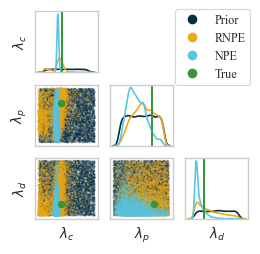

In [13]:
# Plot posterior pairplot?
# Dataframe for posteriors

thetas = {
    "Prior": res["data"]["theta"],
    "RNPE": res["posterior_samples"]["RNPE"],
    "NPE": res["posterior_samples"]["NPE"],
    }

p = pairplot(
    thetas, res["data"]["theta_true"],
    col_names = res["names"]["theta"],
    colors = [colors[0], colors[2], colors[1], colors[-1]],
    array_point_size=1.5,
    legend_pos=(0.93, 0.91))

ax = p.axes
p.set_size_inches(5.5/2, 5.5/2)
[a.tick_params(axis="both", direction="in", pad=0.13) for a in ax]
p.savefig(f"{results_dir}/plots/cancer_posterior.pdf")


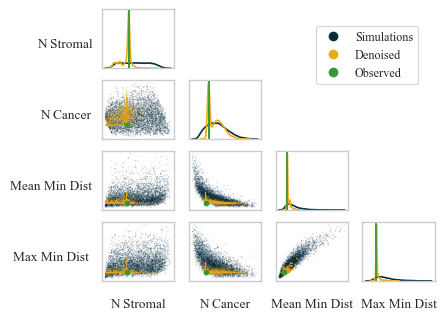

In [14]:
fig = denoised_pairplot(res, legend_pos=(0.875, 0.85));
yaxes = [ax for ax in fig.get_axes() if ax.get_ylabel() != ""]
x_pads = [0.5, 0.5, 0.7, 0.7]

for ax, pad in zip(yaxes, x_pads):
    ax.set_ylabel(ax.get_ylabel(), rotation=0)
    ax.yaxis.set_label_coords(x=-pad, y=0.3)

fig.set_size_inches(4.3, 3.6)
fig.savefig(f"{results_dir}/plots/cancer_denosied_pairplot.pdf", bbox_inches="tight", dpi=400)